In [1]:
from anotherJEPA3 import TrajectoryDataset
import random
import torch
import PIL
import matplotlib.pyplot as plt

In [110]:

def shift_augmentation(states, actions):
    """
    Example augmentation function for the TrajectoryDataset.
    Args:
        states (Tensor): Tensor of shape (T, 2, 64, 64).
        actions (Tensor): Tensor of shape (T-1, 2).
    
    Returns:
        Tuple[Tensor, Tensor]: Augmented states and actions.
    """
    # Check for edges of the agent
    _, _, width_non_zeros = torch.nonzero((states[:, 0] != 0), as_tuple=True)
    width_min = width_non_zeros.min().item()
    width_max = width_non_zeros.max().item()

    # Check for edges of the walls
    wall_non_zeros = torch.nonzero(states[-1, 1, 0, 5:-5] != 0)
    wall_min = wall_non_zeros.min().item()+5
    wall_max = wall_non_zeros.max().item()+5

    wall_pos = int((wall_min+wall_max)/2)


    # Identify range of the data (lowest and highest index where it is not empty space)
    global_min_all = min(width_min, width_max, wall_min, wall_max)
    global_max_all = max(width_min, width_max, wall_min, wall_max)

    # Randomly determine shift (without breaking out of the box)
    min_shift = 5 - global_min_all
    max_shift = 59 - global_max_all
    if global_min_all < 5 or global_max_all > 59:
        shift = 0
    elif min_shift is not max_shift+1 or min_shift is not max_shift:
        try:
            shift = torch.randint(min_shift, max_shift + 1, size=(1,))
        except:
            shift = 0
    else:
        shift = min_shift

    if isinstance(shift, torch.Tensor):
        shift = shift.item()
    print(shift)

    # In-place shift for the first channel (primary state)
    states[:, 0].copy_(torch.roll(states[:, 0], shifts=shift, dims=2))
    
    # Special handling for walls (second channel)
    # Separate the edges and core
    left_edge = states[:, 1, :, 0:5].clone()
    right_edge = states[:, 1, :, -5:].clone()
    core = states[:, 1, :, 5:-5]
    
    # In-place shift of the core part
    shifted_core = torch.roll(core, shifts=shift, dims=2)
    
    # Reconstruct the wall channel
    states[:, 1, :, 5:-5] = shifted_core
    
    return states, actions

-4


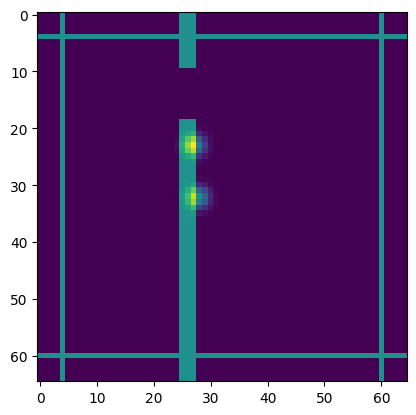

In [120]:
dataset = TrajectoryDataset('../data/states.npy', '../data/actions.npy', augmentations=[shift_augmentation])
states, actions = dataset[12]  # This will print "augmenting"

start = states[0][0]  # Example indexing to get the tensor
end = states[-1][0]
walls = states[0][1]

plt.imshow(start+end+walls)